Found cached dataset fashion_mnist (/Users/arun/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

{'Accuracy': '0.586', 'loss': '1.371', 'epoch': 0, 'train': 'train'}
{'Accuracy': '0.687', 'loss': '0.893', 'epoch': 0, 'train': 'val'}
{'Accuracy': '0.727', 'loss': '0.790', 'epoch': 1, 'train': 'train'}
{'Accuracy': '0.750', 'loss': '0.724', 'epoch': 1, 'train': 'val'}
{'Accuracy': '0.753', 'loss': '0.697', 'epoch': 2, 'train': 'train'}
{'Accuracy': '0.753', 'loss': '0.687', 'epoch': 2, 'train': 'val'}


Accuracy,loss,epoch,train
0.594,1.417,0,train
0.701,0.899,0,val
0.720,0.798,1,train
0.736,0.724,1,val
0.756,0.689,2,train
0.775,0.642,2,val


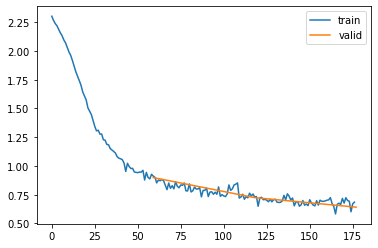

Accuracy,loss,epoch,train
0.677,0.923,0,train
0.811,0.546,0,val
0.823,0.505,1,train
0.816,0.505,1,val


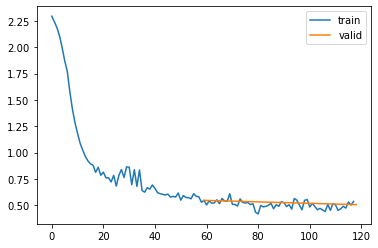

In [2]:
from miniai.lec_9_v5 import *

In [37]:
name = 'fashion_mnist'
bs = 1024

@inplace
def transformi_(b):
    x,y = 'image','label'
    b[x] = [TF.to_tensor(ele) for ele in b[x]]

rds = load_dataset(name)
tds = rds.with_transform(transformi_)
dls = DataLoaders.from_dd(tds, batch_size=bs)

Found cached dataset fashion_mnist (/Users/arun/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [46]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, kernel_size=ks, stride=2, padding=ks//2)
    if act:
        res = nn.Sequential(*[
            res,
            nn.ReLU()
        ])
    return res

def get_cnn_layers():
    return [
        conv(1, 8, ks=5),
        conv(8, 16),
        conv(16, 32),
        conv(32, 64),
        conv(64, 10, act=False),
        nn.Flatten()
    ]

In [42]:
def fit(model, epochs=1, xtra_cbs=None):
    learner = Learner(model, dls=dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learner.fit(epochs)
    return learner 

In [43]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), metrics, ProgressCB(plot=True)]

In [47]:
model = nn.Sequential(*get_cnn_layers())

accuracy,loss,epoch,train
0.210,2.261,0,train
0.100,2.323,0,val


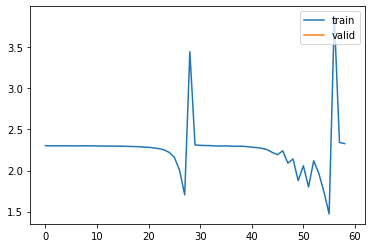

In [48]:
learner = fit(model)

In [53]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in self.layers]
        self.act_std = [[] for _ in self.layers]
    
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.detach().mean())
            self.act_std[i].append(x.detach().std())
        return x
    
    def __iter__(self):
        return iter(self.layers)

In [54]:
model = SequentialModel(*get_cnn_layers())

accuracy,loss,epoch,train
0.128,2.324,0,train
0.100,2.302,0,val


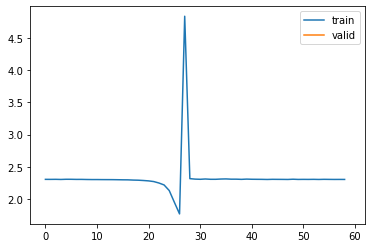

In [55]:
learn = fit(model)

In [59]:
len(model.act_means[1])

89

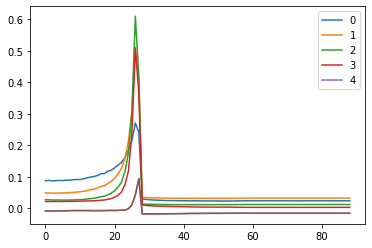

In [64]:
for l in model.act_means:
    plt.plot(l)
plt.legend(range(5))

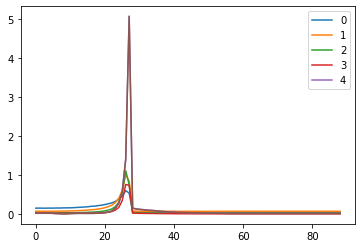

In [65]:
for l in model.act_std:
    plt.plot(l)
plt.legend(range(5))

In [78]:
model = nn.Sequential(*get_cnn_layers())

In [79]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

In [80]:
def append_stats(i, m, inp, out):
    act_means[i].append(out.detach().mean())
    act_stds[i].append(out.detach().std())

In [81]:
for i,l in enumerate(model):
    l.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.164,2.299,0,train
0.195,2.240,0,val


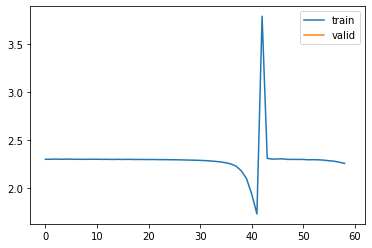

In [82]:
fit(model)

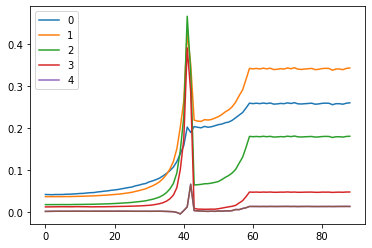

In [83]:
for l in act_means:
    plt.plot(l)
plt.legend(range(5))

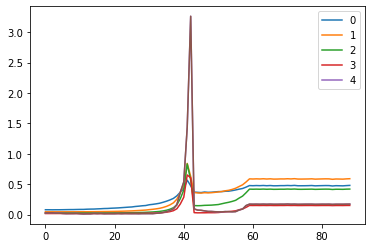

In [84]:
for l in act_stds:
    plt.plot(l)
plt.legend(range(5))

In [90]:
class Hook:
    def __init__(self, m, f):
        self.hook = m.register_forward_hook(partial(f, self))
    
    def remove(self):
        self.hook.remove()
    
    def __del__(self):
        self.remove()

In [91]:
def append_stats(hook, m, inpt, out):
    if not hasattr(hook, 'stats'):
        hook.stats = ([],[])
    act = out.detach()
    hook.stats[0].append(act.mean())
    hook.stats[1].append(act.std())

In [92]:
model = nn.Sequential(*get_cnn_layers())

In [93]:
hooks = [Hook(l, append_stats) for l in model]

accuracy,loss,epoch,train
0.178,2.229,0,train
0.258,1.897,0,val


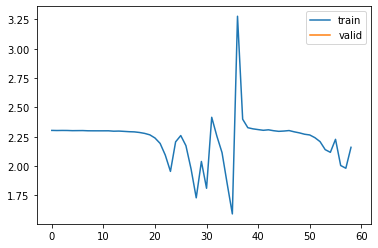

In [94]:
fit(model)

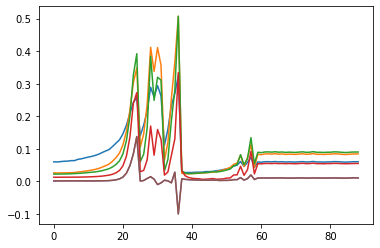

In [95]:
for h in hooks:
    plt.plot(h.stats[0])

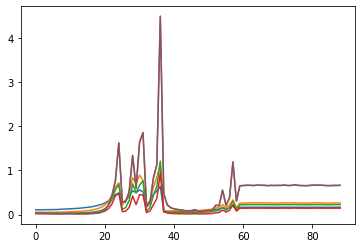

In [96]:
for h in hooks:
    plt.plot(h.stats[1])

In [100]:
class Hooks(list):
    def __init__(self, ms, f):
        super().__init__([Hook(l, f) for l in ms])
    
    def remove(self):
        for h in self:
            h.remove()
    
    def __enter__(self):
        return self
    
    def __exit__(self, *args):
        self.remove()
    
    def __del__(self):
        self.remove()
    
    def __delitem__(self, i):
        self[i].remove()
        super().__dellitem__(i)

In [105]:
model = nn.Sequential(*get_cnn_layers())

accuracy,loss,epoch,train
0.201,2.260,0,train
0.100,2.301,0,val


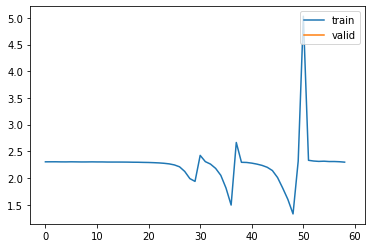

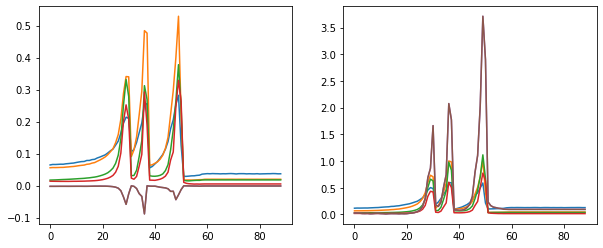

In [106]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks:
        for i in (0,1):
            axs[i].plot(h.stats[i])

In [113]:
class HooksCB(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_val=False, mods=None,):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn):
        if self.mods:
            mods = mods
        else:
            mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))
    
    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_val and not learn.learning):
            self.hookfunc(*args, **kwargs)
    
    def after_fit(self, learn):
        self.hooks.remove()
    
    def __iter__(self):
        return iter(self.hooks)
    
    def __len__(self):
        return len(self.hooks)

In [114]:
hc = HooksCB(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

In [115]:
model = nn.Sequential(*get_cnn_layers())

accuracy,loss,epoch,train
0.185,2.310,0,train
0.116,2.301,0,val


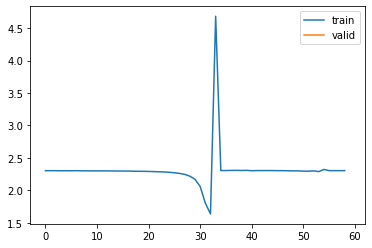

In [116]:
fit(model, xtra_cbs=[hc])

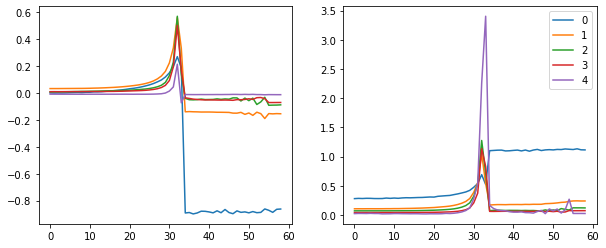

In [120]:
fig,axs = plt.subplots(1, 2, figsize=(10, 4))
for h in hc:
    for i in (0,1):
        axs[i].plot(h.stats[i])
plt.legend(range(5))

In [134]:
t = torch.tensor([
    1, 2, -3, 4
])

In [286]:
def append_stats(hook, mod, inp, outp):
    act = outp.detach()
    if not hasattr(hook, 'stats'):
        hook.stats = ([],[],[])
    hook.stats[0].append(act.mean())
    hook.stats[1].append(act.std())
    hook.stats[2].append(act.abs().histc(40, 0, 10))

accuracy,loss,epoch,train
0.168,2.304,0,train
0.100,2.310,0,val


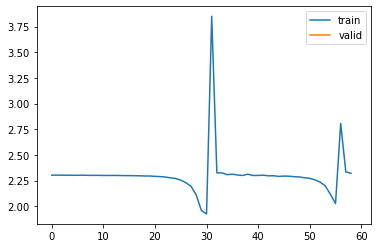

In [287]:
model = nn.Sequential(*get_cnn_layers())
hc = HooksCB(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc]);

In [288]:
import math
import numpy as np

@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

In [289]:
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

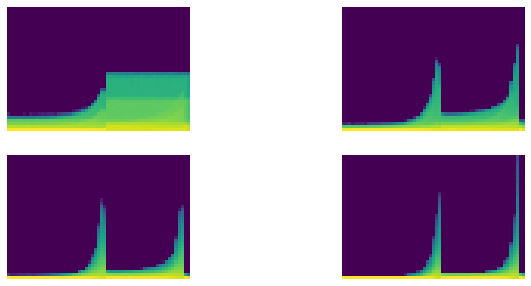

In [290]:
mpl.rcParams['image.cmap'] = 'viridis'
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')

In [296]:
for h in hc:
    break

In [306]:
len(h.stats[2][0])

40

In [320]:
torch.stack(h.stats[2]).shape

torch.Size([59, 40])

In [336]:
torch.stack(h.stats[2]).t().float().log1p().max()

tensor(14.03)

In [361]:
torch.stack(h.stats[2]).t().float().log1p()[0]

tensor([14.02, 14.02, 14.02, 14.02, 14.01, 14.03, 14.01, 14.02, 14.02, 14.01, 14.00, 14.01, 14.01, 14.01, 14.00, 14.00, 14.00, 14.00, 13.99,
        13.98, 13.98, 13.97, 13.98, 13.96, 13.96, 13.95, 13.93, 13.92, 13.90, 13.89, 13.88, 13.89, 13.19, 13.20, 13.20, 13.20, 13.21, 13.20,
        13.20, 13.19, 13.20, 13.18, 13.21, 13.19, 13.20, 13.20, 13.19, 13.28, 13.29, 13.30, 13.28, 13.28, 13.28, 13.27, 13.26, 13.26, 13.25,
        13.29, 12.77])

In [345]:
torch.log1p??

In [353]:
torch.tensor([2, 1, 1.]).histc(40, 0, 10)

tensor([0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])

In [379]:
t = torch.stack(h.stats[2]).t().float().log1p()
t.shape

torch.Size([40, 59])

In [382]:
t

tensor([[14.02, 14.02, 14.02,  ..., 13.25, 13.29, 12.77],
        [12.49, 12.49, 12.50,  ..., 12.74, 13.14, 12.62],
        [11.24, 11.25, 11.25,  ..., 12.09, 11.97, 11.43],
        ...,
        [ 0.00,  0.00,  0.00,  ...,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  ...,  0.00,  0.00,  0.00],
        [ 0.00,  0.00,  0.00,  ...,  0.00,  0.00,  0.00]])

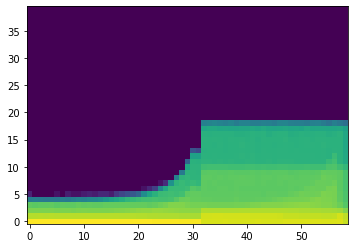

In [387]:
mpl.rcParams['image.cmap'] = 'viridis'
plt.imshow(t, origin='lower')

In [390]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

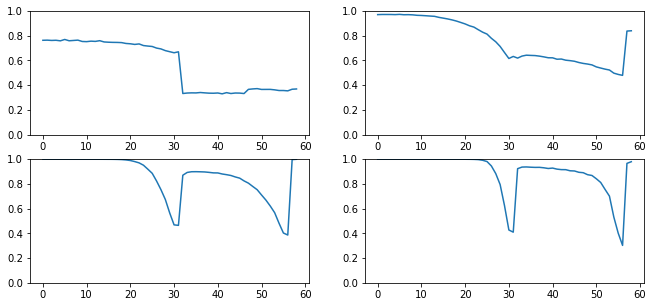

In [391]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)    

In [404]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

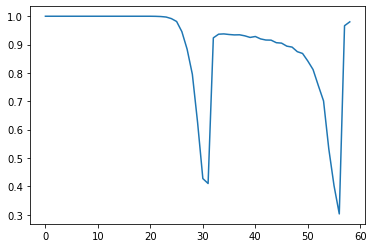

In [406]:
plt.plot(get_min(h))

In [ ]:
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

In [409]:
class ActivationStats(HooksCB):
    def __init__(self, mod_filter=fc.noop):
        super().__init__(append_stats, mod_filter)
    
    def color_dim(self, figsize=(11, 5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')
    
    def dead_chart(self, figsize=(11, 5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0, 1)
    
    def plot_stats(self, figsize=(10, 4)):
        fig,axes = plt.subplots(1, 2, figsize=figsize)
        for h in self:
            for i in 0,1:
                axes[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

In [410]:
acstats = ActivationStats(mod_filter=fc.risinstance(nn.Conv2d))

In [411]:
model = nn.Sequential(*get_cnn_layers())

accuracy,loss,epoch,train
0.166,2.335,0,train
0.100,2.301,0,val


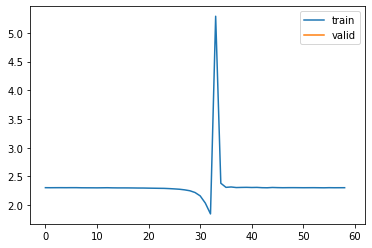

In [412]:
fit(model, xtra_cbs=[acstats])

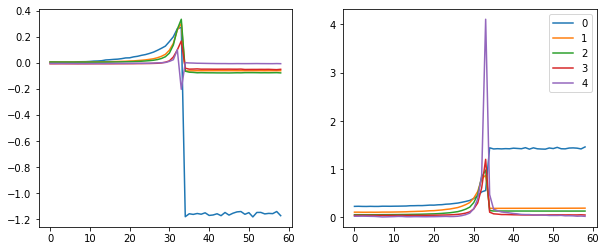

In [413]:
acstats.plot_stats()

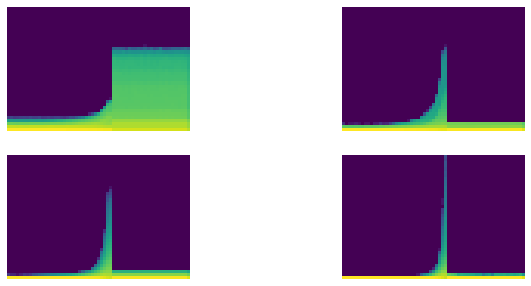

In [415]:
acstats.color_dim()

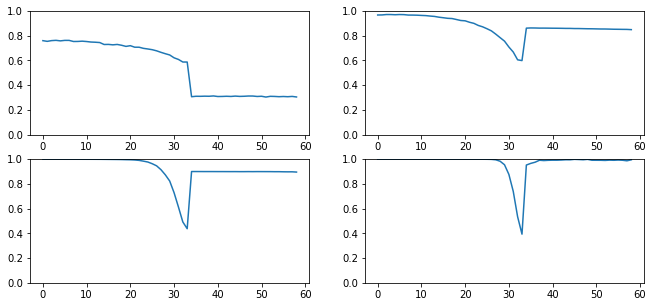

In [416]:
acstats.dead_chart()